In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import convolve2d
from skimage.restoration import denoise_bilateral
import cv2

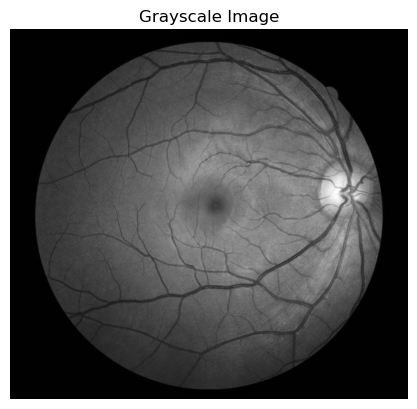

Max Intensity:  235
Min Intensity:  0


In [99]:
# Load the retinal fundus image in grayscale
image_path = 'Fundus.jpeg'
img = cv2.imread(image_path)
if img is None:
    raise IOError("Image not found. Check the image path.")

# Convert to RGB (OpenCV loads images in BGR format by default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()
print("Max Intensity: ",np.max(gray_img))
print("Min Intensity: ",np.min(gray_img))

In [100]:
def apply_median_filter(image, kernel_size=5):
    """
    Applies a median filter to reduce noise in fundus images.

    Parameters:
        image (numpy.ndarray): Input fundus image (BGR or grayscale)
        kernel_size (int): Size of the median filter kernel (must be odd and >1)

    Returns:
        numpy.ndarray: Filtered image
    """
    # Ensure kernel size is odd
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd integer")

    # Apply median filter
    filtered_image = cv2.medianBlur(image, kernel_size)

    return filtered_image

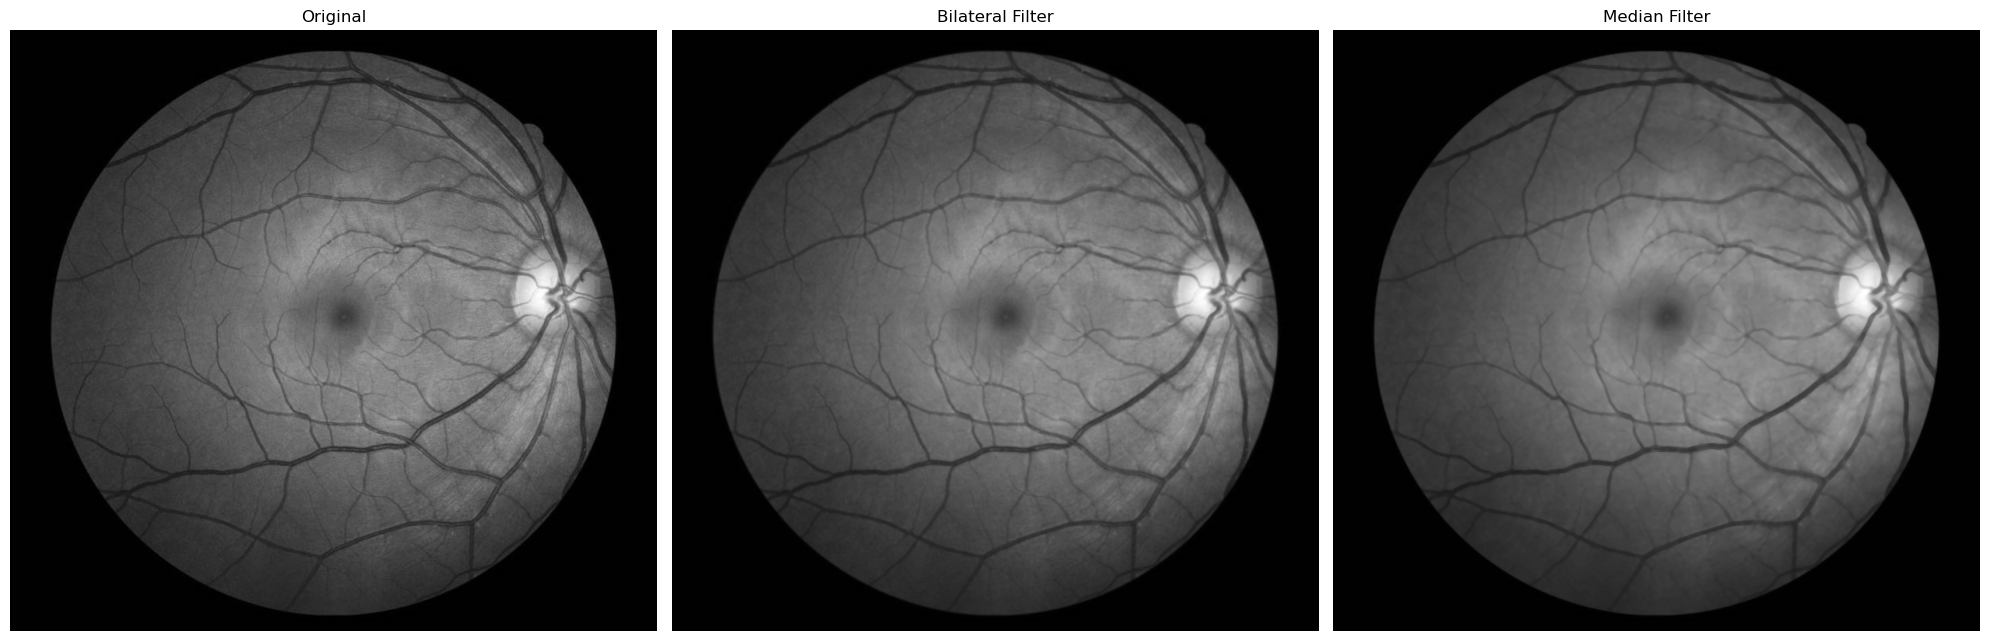

In [101]:
# Perform built-in bilateral (OpenCV)
gray_img_bilateral = cv2.bilateralFilter(gray_img, d=5, sigmaColor=50, sigmaSpace=0)

# Apply median filter with 5x5 kernel
gray_img_median = apply_median_filter(gray_img, kernel_size=5)

# Plot results
plt.figure(figsize=(20, 8))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(gray_img, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Bilateral Filter")
plt.imshow(gray_img_bilateral, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Median Filter")
plt.imshow(gray_img_median, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

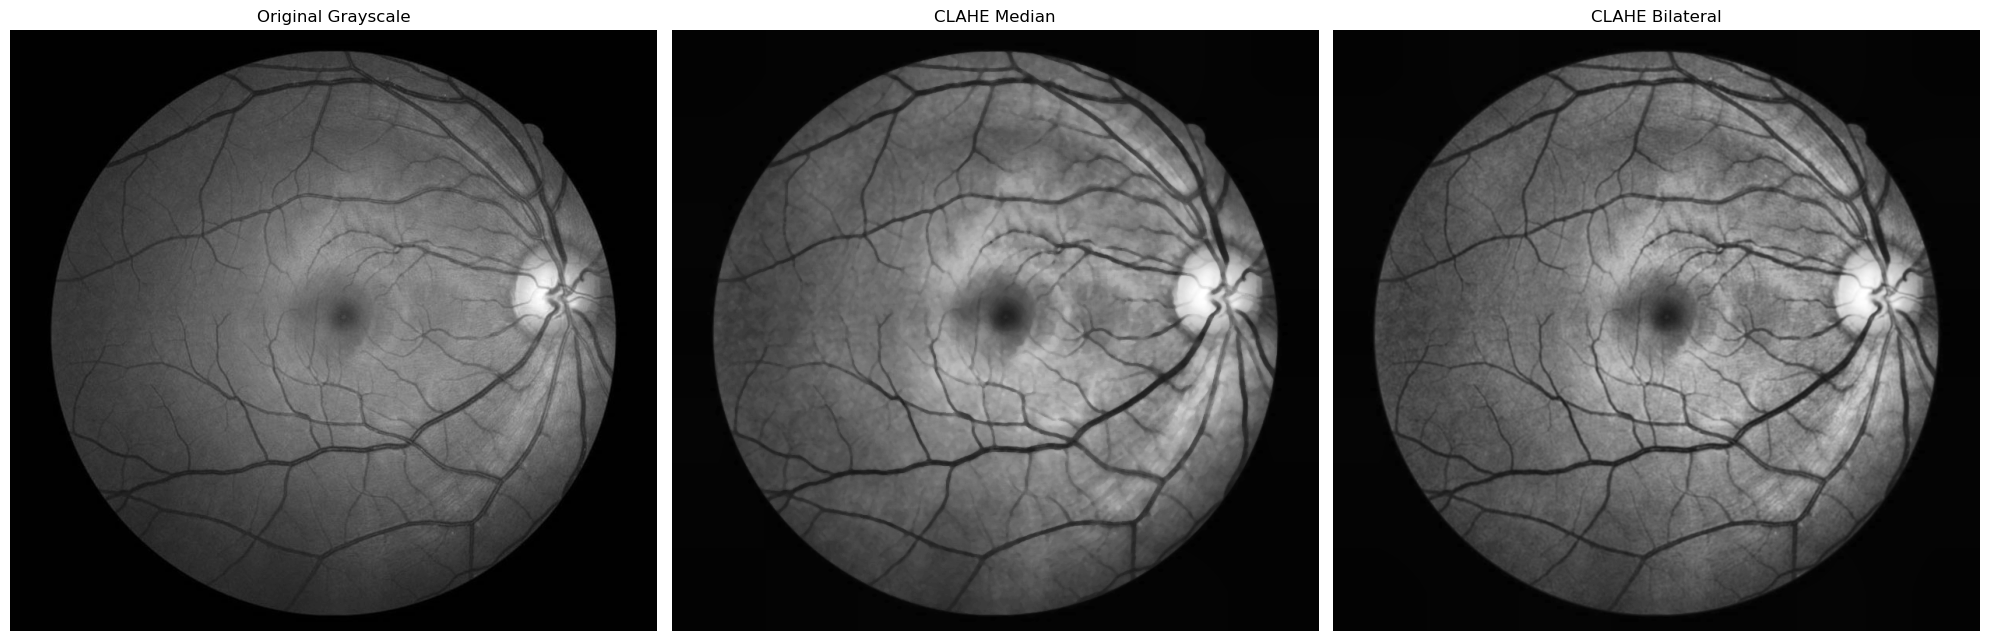

In [102]:
# Create a CLAHE object for comparison
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(7,7))
clahe_median = clahe.apply(gray_img_median)
clahe_bilateral = clahe.apply(gray_img_bilateral)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
# Original
axes[0].imshow(gray_img, cmap='gray')
axes[0].set_title("Original Grayscale")
axes[0].axis("off")

# Manual Histogram Equalized
axes[1].imshow(clahe_median, cmap='gray')
axes[1].set_title("CLAHE Median")
axes[1].axis("off")

# CLAHE
axes[2].imshow(clahe_bilateral, cmap='gray')
axes[2].set_title("CLAHE Bilateral")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [103]:
def manual_scharr(gray_img):
    """
    Perform manual Scharr filtering using the 3x3 Scharr operator.
    Returns:
      I_x: gradient in x-direction
      I_y: gradient in y-direction
      magnitude: sqrt(I_x^2 + I_y^2)
      orientation: arctan(I_y / I_x), in radians
    """
    # Define Scharr kernels (float64 for accumulation)
    Gx = np.array([[-3, 0, 3],
                   [-10, 0, 10],
                   [ -3, 0, 3]], dtype=np.float64)

    Gy = np.array([[-3, -10, -3],
                   [ 0,   0,  0],
                   [ 3,  10,  3]], dtype=np.float64)

    # Convert image to float64 to avoid overflow in convolution
    img_float = gray_img.astype(np.float64)

    # Convolve with Gx and Gy
    # mode='same' ensures output is the same size as input
    # boundary='symm' handles boundaries by reflecting image
    I_x = convolve2d(img_float, Gx, mode='same', boundary='symm')
    I_y = convolve2d(img_float, Gy, mode='same', boundary='symm')

    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(I_x**2 + I_y**2)
    orientation = np.arctan2(I_y, I_x)  # arctan2 handles sign of x,y

    return I_x, I_y, magnitude, orientation

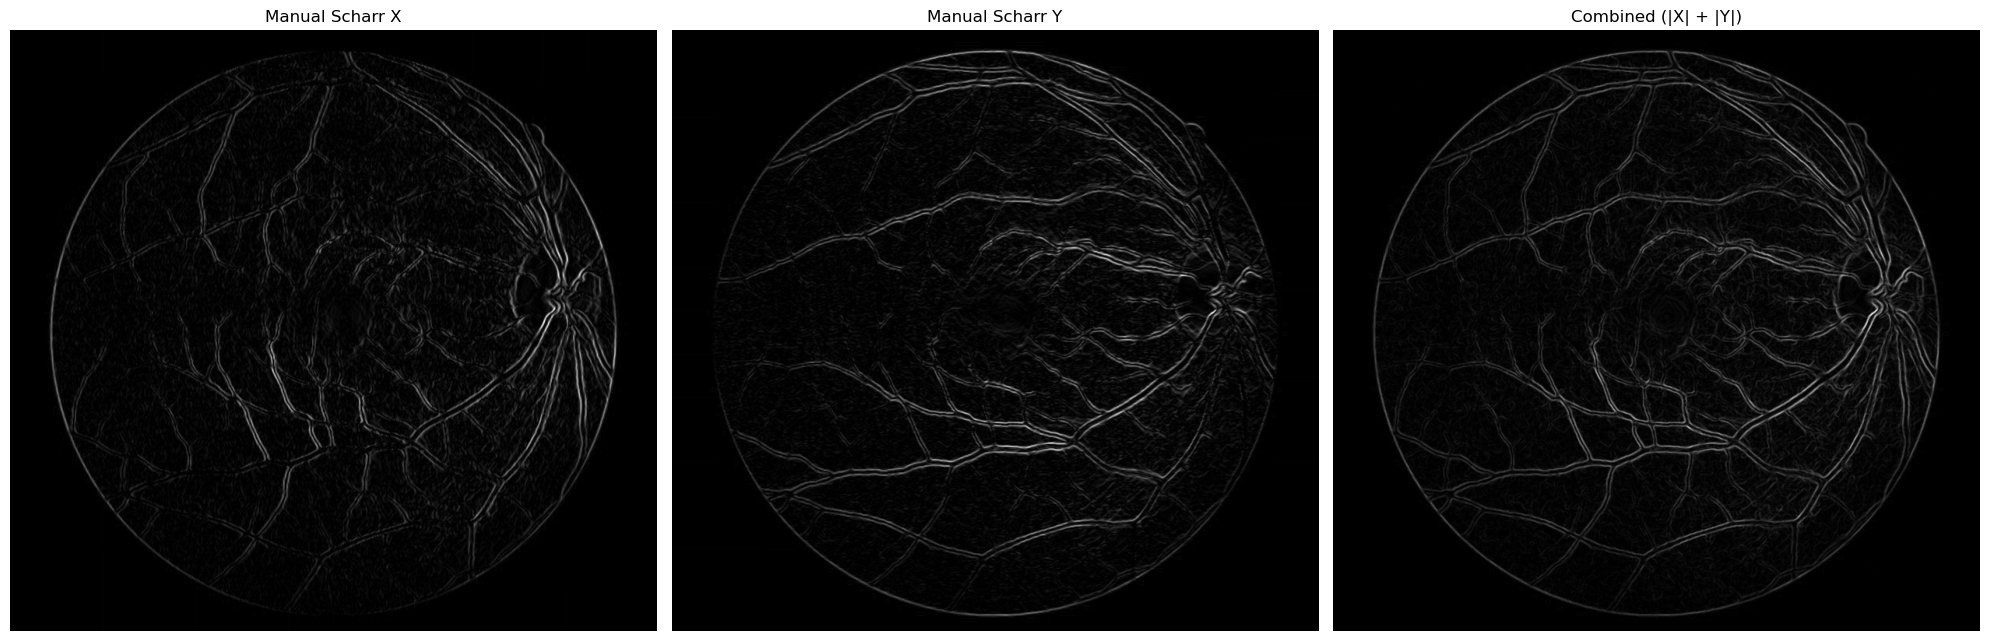

In [104]:
# Manual Scharr Filtering
I_x_manual, I_y_manual, mag_manual, orient_manual = manual_scharr(clahe_median)

# Scharr in X, Y: often contain negative values, so display absolute or scaled version
I_x_disp = np.uint8(255 * (np.abs(I_x_manual) / np.max(np.abs(I_x_manual))))
I_y_disp = np.uint8(255 * (np.abs(I_y_manual) / np.max(np.abs(I_y_manual))))

# Combined version using weighted sum of absolute values
combined = 0.5 * np.abs(I_x_manual) + 0.5 * np.abs(I_y_manual)
combined_disp = np.uint8(255 * (combined / np.max(combined)))

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# (a) Scharr X
axes[0].imshow(I_x_disp, cmap='gray')
axes[0].set_title('Manual Scharr X')
axes[0].axis('off')

# (b) Scharr Y
axes[1].imshow(I_y_disp, cmap='gray')
axes[1].set_title('Manual Scharr Y')
axes[1].axis('off')

# (c) Combined
axes[2].imshow(combined_disp, cmap='gray')
axes[2].set_title('Combined (|X| + |Y|)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [105]:
def create_LoG_kernel(kernel_size, sigma):
    """
    Create a Laplacian of Gaussian (LoG) kernel.

    Equation:
        LoG(x, y) = (1 / (pi * sigma^4)) * (1 - ((x^2 + y^2) / (2 * σ^2))) * exp(-(x² + y²) / (2σ²))

    Parameters:
        kernel_size (int): Size of the kernel (must be an odd number).
        sigma (float): Standard deviation of the Gaussian.

    Returns:
        numpy.ndarray: LoG kernel.
    """
    # Create coordinate grid centered at 0
    ax = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    norm2 = xx**2 + yy**2

    # Compute the LoG function
    factor = 1 / (np.pi * sigma**4)
    kernel = factor * (1 - norm2 / (2 * sigma**2)) * np.exp(-norm2 / (2 * sigma**2))

    # Normalize kernel to ensure zero-sum
    kernel_mean = kernel.mean()
    kernel = kernel - kernel_mean

    return kernel

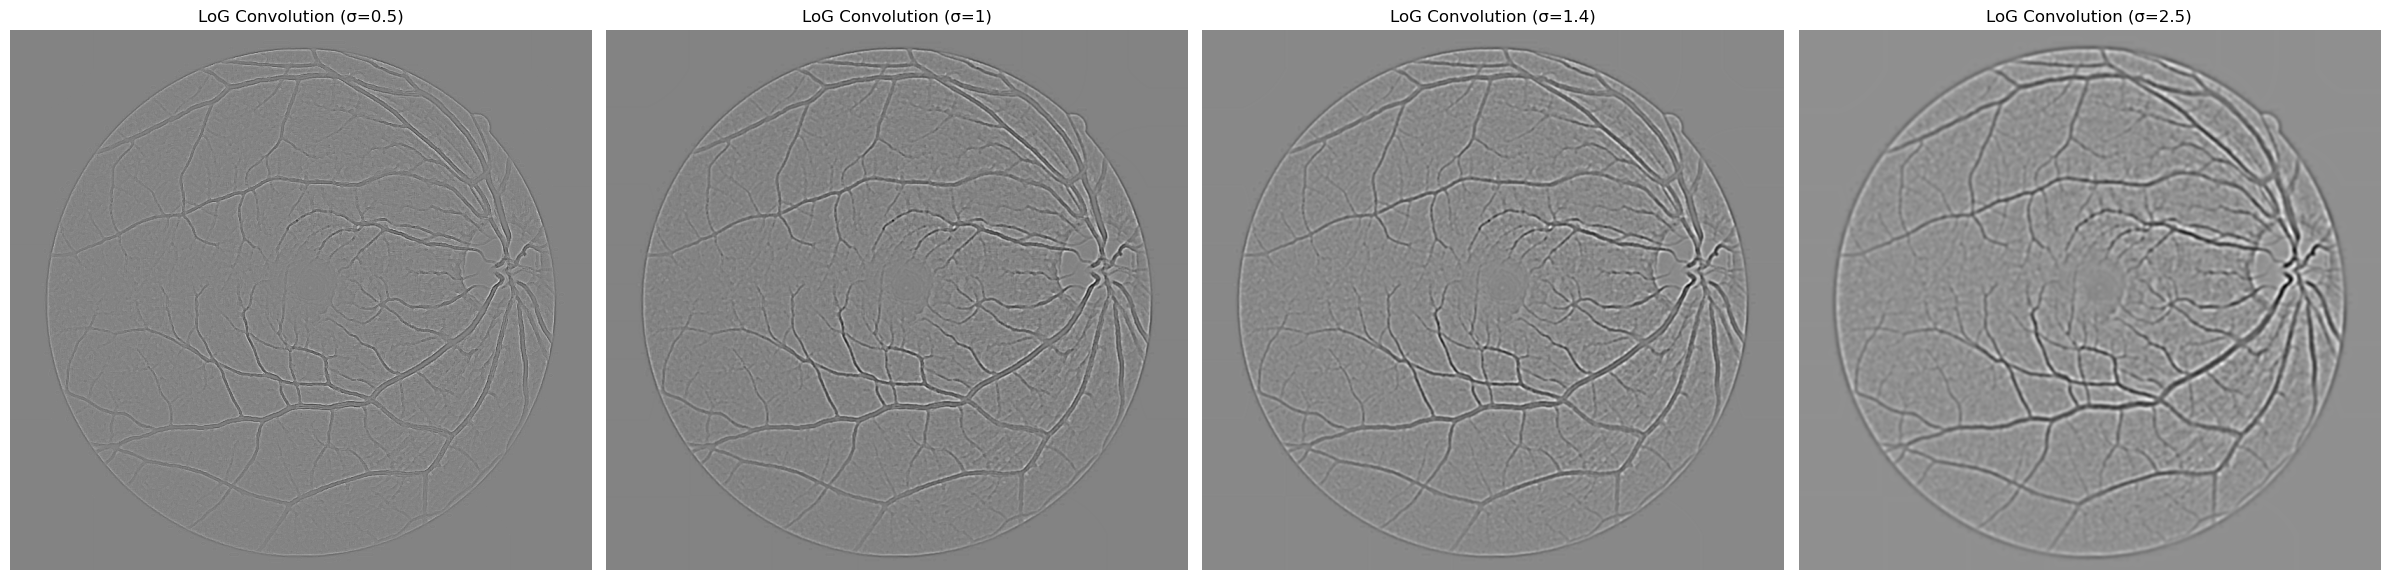

In [109]:
sigmas_LoG = [0.5, 1, 1.4, 2.5]
results_LoG = []  # to store convolved images for each sigma

for sigma in sigmas_LoG:
    kernel_size = int(np.ceil(6 * sigma + 1))  # typical rule of thumb
    kernel_LoG = create_LoG_kernel(kernel_size, sigma)

    # Convolve
    convolved_LoG = signal.convolve2d(clahe_median, kernel_LoG, boundary='symm', mode='same')

    # Normalize to [0, 255] for display
    # NOTE: LoG can have negative values; here we do a simple linear shift.
    min_val = convolved_LoG.min()
    max_val = convolved_LoG.max()
    convolved_LoG -= min_val
    if (max_val - min_val) > 1e-12:
        convolved_LoG *= (255.0 / (max_val - min_val))

    results_LoG.append((sigma, convolved_LoG))

# 3) Plot only the convolved images for each sigma
num_scales = len(sigmas_LoG)
fig, axes = plt.subplots(1, num_scales, figsize=(6 * num_scales, 10))

for i, (sigma, convolved_LoG) in enumerate(results_LoG):
    ax = axes[i] if num_scales > 1 else axes
    ax.set_title(f"LoG Convolution (σ={sigma})")
    ax.imshow(convolved_LoG, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()